In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# model flag
model_name = 'LASSO'

### load data


In [3]:
### load data
df01 = pd.read_csv('factors_with_rf_standardized.csv')

# inport index data
df_index = pd.read_csv('index_excess_return.csv')

In [4]:
df_index.head()

,Date,index_return
0,2000-01-01,0.121386
1,2000-02-01,0.115134
2,2000-03-01,0.048092
3,2000-04-01,0.018197
4,2000-05-01,0.029854


In [5]:
# Convert index dates to datetime
df_index['Date'] = pd.to_datetime(df_index['Date'])

# Filter for test period (2012-2014) 
df_index = df_index[
    (df_index['Date'].dt.year >= 2012) & 
    (df_index['Date'] <= '2014-12-31')
]

In [6]:
df01.columns

Index(['Symbol', 'Date', 'beta', 'beta_squared', 'chcsho', 'ill', 'mve',
       'std_dolvol', 'std_turn', 'zerotrade', 'return', 'market_cap', 'bm',
       'bm_ia', 'cash', 'cashdebt', 'cashspr', 'cfp', 'cfp_ia', 'chato',
       'chato_ia', 'acc', 'absacc', 'agr', 'rf', 'excess_return',
       'next_month_excess_return'],
      dtype='object')

In [7]:
factor_columns = ['bm', 'bm_ia', 'cash', 'cashdebt', 'cashspr', 'cfp',
                   'cfp_ia', 'chato', 'chato_ia', 'acc', 'absacc', 'agr', 
                   'beta', 'beta_squared', 'chcsho', 'ill', 'mve', 
                   'std_dolvol', 'std_turn', 'zerotrade']

# Convert Date to datetime for splitting
df01['Date'] = pd.to_datetime(df01['Date'])

### model training

validation periods are used for hyperparameter tuning

In [8]:
"""
Parameter Explanation:
1. Purpose: Alpha is the regularization parameter in LASSO regression that controls L1 penalty strength
   - Larger alpha: Stronger regularization, more coefficients are shrunk to zero
   - Smaller alpha: Weaker regularization, model approaches standard linear regression

2. Parameter Range Setting: np.logspace(-4, -1, 100)
   - Start: 10^-4 = 0.0001 (very weak regularization)
   - End: 10^-1 = 0.1 (relatively strong regularization)
   - Points: 100 points (logarithmically spaced in this range)
"""

# Define finer grid of alpha values using logspace
alphas = np.logspace(-4, -1, 100)  # 100 values from 10^-4 to 10^-1


Total training time for 100 models: 3.55 seconds
Average time per model: 0.0355 seconds


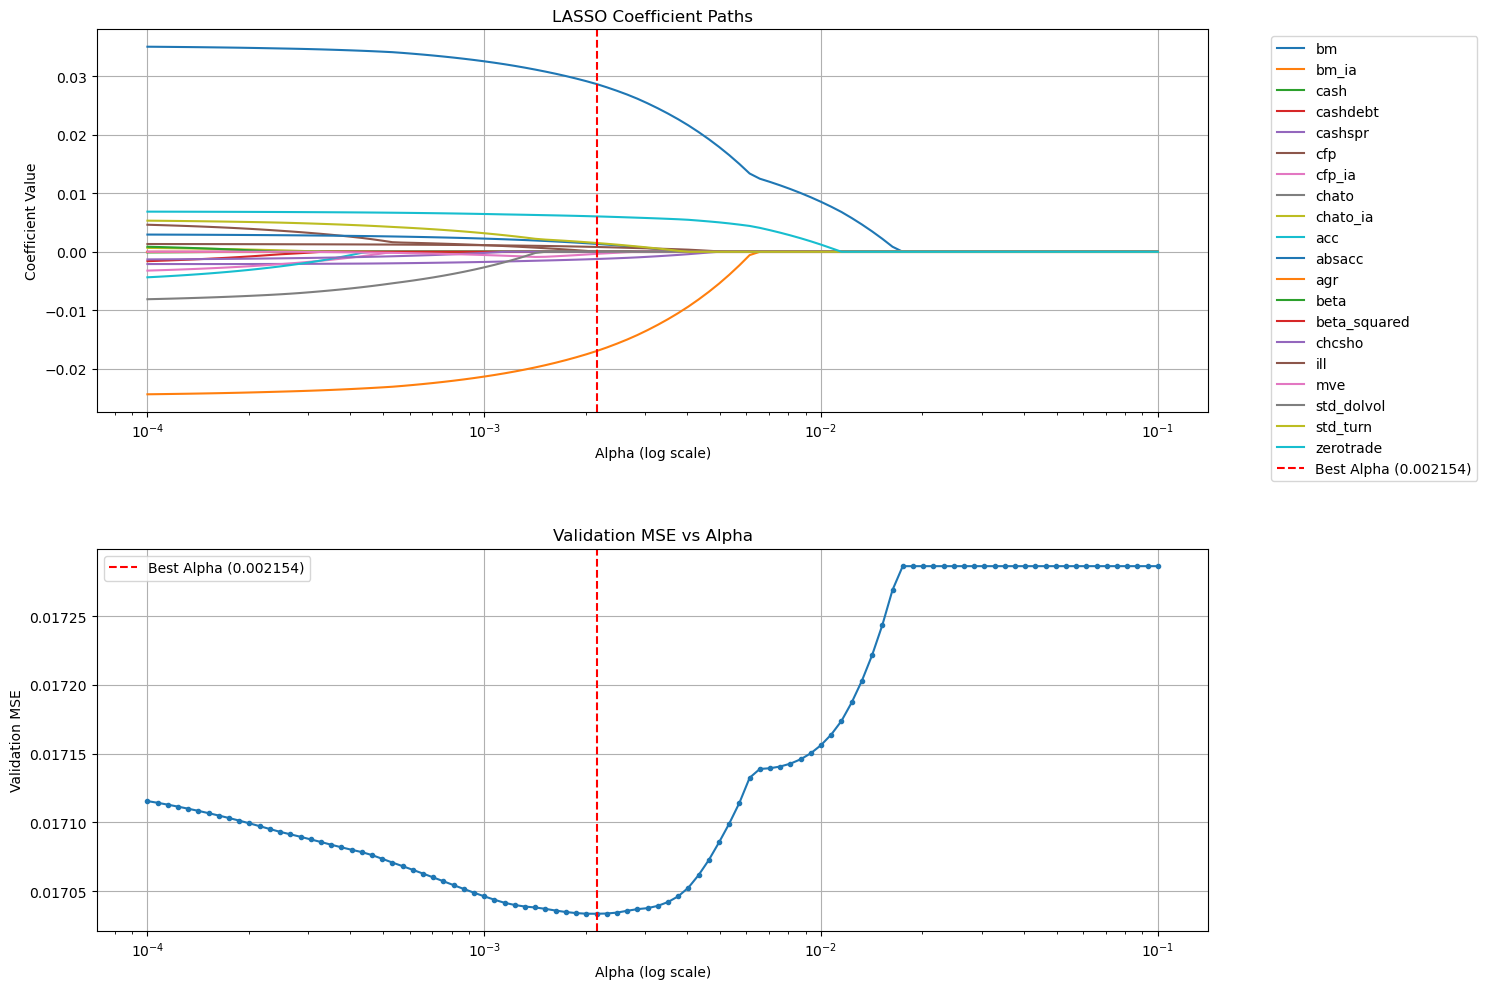


Best alpha: 0.002154

Validation Period (2009-2011):
MSE: 0.017034
RMSE: 0.130513
R²: 0.014134

Selected features:
      Feature  Coefficient
0          bm     0.028633
1       bm_ia    -0.016956
19  zerotrade     0.006036
18   std_turn     0.001496
10     absacc     0.001345
4     cashspr    -0.001237
15        ill     0.000818
16        mve    -0.000355
5         cfp     0.000014

Test Period (2012-2014):
MSE: 0.021201
RMSE: 0.145605
R²: -0.013867


In [9]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time

# Create time-based splits
train_mask = (df01['Date'].dt.year >= 2000) & (df01['Date'].dt.year <= 2008)
val_mask = (df01['Date'].dt.year >= 2009) & (df01['Date'].dt.year <= 2011)
test_mask = (df01['Date'].dt.year >= 2012) & (df01['Date'].dt.year <= 2014)

# Prepare features and target
X = df01[factor_columns]
y = df01['next_month_excess_return']

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Step 1: Train models with different alphas using training data (2000-2008)
validation_metrics = []
coefs_path = []

# Start timing for all model training
total_start_time = time.time()

# Train models and collect metrics for each alpha
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    model.fit(X_train, y_train)
    
    # Store coefficients
    coefs_path.append(model.coef_)
    
    # Step 2: Evaluate on validation data (2009-2011) to select best alpha
    val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    validation_metrics.append({
        'alpha': alpha,
        'mse': val_mse,
        'r2': val_r2,
        'model': model
    })

total_end_time = time.time()
total_training_time = total_end_time - total_start_time

# Print timing results
print(f"\nTotal training time for {len(alphas)} models: {total_training_time:.2f} seconds")
print(f"Average time per model: {total_training_time/len(alphas):.4f} seconds")

# Find best model based on validation performance
best_result = min(validation_metrics, key=lambda x: x['mse'])
best_alpha = best_result['alpha']
best_model = best_result['model']

# Create visualizations of model selection process
plt.figure(figsize=(15, 10))

# 1. Coefficient Paths Plot
plt.subplot(2, 1, 1)
coefs_path = np.array(coefs_path)
for i in range(X_train.shape[1]):
    plt.semilogx(alphas, coefs_path[:, i], label=f'{factor_columns[i]}')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best Alpha ({best_alpha:.6f})')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('LASSO Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 2. Validation MSE vs Alpha Plot
plt.subplot(2, 1, 2)
mse_values = [m['mse'] for m in validation_metrics]
plt.semilogx(alphas, mse_values, marker='.')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best Alpha ({best_alpha:.6f})')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Alpha')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print validation results
print(f"\nBest alpha: {best_alpha:.6f}")
print("\nValidation Period (2009-2011):")
print(f"MSE: {best_result['mse']:.6f}")
print(f"RMSE: {np.sqrt(best_result['mse']):.6f}")
print(f"R²: {best_result['r2']:.6f}")

# Print selected features and their importance
feature_importance = pd.DataFrame({
    'Feature': factor_columns,
    'Coefficient': best_model.coef_
})
feature_importance = feature_importance[feature_importance['Coefficient'] != 0]
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nSelected features:")
print(feature_importance)

# Step 3: Use best model to make predictions on test set (2012-2014)
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\nTest Period (2012-2014):")
print(f"MSE: {test_mse:.6f}")
print(f"RMSE: {np.sqrt(test_mse):.6f}")
print(f"R²: {test_r2:.6f}")

In [10]:
# Create portfolio DataFrame for test period
portfolio_df = df01[test_mask].copy()
portfolio_df['Predicted'] = test_predictions
portfolio_df['Actual'] = portfolio_df['next_month_excess_return']
portfolio_df.head()


,Symbol,Date,beta,beta_squared,chcsho,ill,mve,std_dolvol,std_turn,zerotrade,...,chato,chato_ia,acc,absacc,agr,rf,excess_return,next_month_excess_return,Predicted,Actual
142,1,2012-01-01,-0.491340,-0.187203,-0.184215,0.204122,2.431100,2.297654,-0.532073,4.940045,...,0.0,0.0,0.0,0.0,-0.014695,0.002871,0.065143,0.025721,0.059893,0.025721
143,1,2012-02-01,-0.577304,-0.210541,-0.184215,0.198468,2.487733,1.205153,-0.642783,0.208799,...,0.0,0.0,0.0,0.0,-0.014695,0.002871,0.025721,-0.086088,0.031143,-0.086088
144,1,2012-03-01,-0.674872,-0.236311,-0.184215,0.191763,2.511427,1.466842,-0.616746,-0.255048,...,0.0,0.0,0.0,0.0,-0.014695,0.002871,-0.086088,0.051355,0.027193,0.051355
145,1,2012-04-01,-0.758517,-0.257794,-0.184215,0.201672,2.437763,1.160609,-0.643931,-0.255043,...,0.0,0.0,0.0,0.0,-0.014695,0.002871,0.051355,-0.055616,0.027187,-0.055616
146,1,2012-05-01,-0.812397,-0.271335,-0.184215,0.192475,2.483546,0.349368,-0.726292,0.187716,...,0.0,0.0,0.0,0.0,-0.014695,0.002871,-0.055616,-0.034620,0.029712,-0.034620


### calculate portfolio return


In [11]:
# Calculate monthly long-only portfolio returns
monthly_long_only = []

for date in portfolio_df['Date'].unique():
    month_data = portfolio_df[portfolio_df['Date'] == date].copy()
    
    # Calculate top decile threshold
    top_threshold = month_data['Predicted'].quantile(0.9)
    
    # Select stocks in top decile
    top_decile = month_data[month_data['Predicted'] >= top_threshold]
    
    # Calculate weights based on market cap 
    top_weights = top_decile['market_cap'] / top_decile['market_cap'].sum()
    
    # Calculate value-weighted return
    top_return = (top_decile['Actual'] * top_weights).sum()
    
    monthly_long_only.append({
        'Date': date,
        'Portfolio_Return': top_return,
        'N_Stocks': len(top_decile)
    })

# Calculate monthly long-short portfolio returns
monthly_long_short = []

for date in portfolio_df['Date'].unique():
    month_data = portfolio_df[portfolio_df['Date'] == date].copy()
    
    # Calculate decile thresholds
    top_threshold = month_data['Predicted'].quantile(0.9)
    bottom_threshold = month_data['Predicted'].quantile(0.1)
    
    # Select stocks in top and bottom deciles
    top_decile = month_data[month_data['Predicted'] >= top_threshold]
    bottom_decile = month_data[month_data['Predicted'] <= bottom_threshold]
    
    # Calculate weights 
    top_weights = top_decile['market_cap'] / top_decile['market_cap'].sum()
    bottom_weights = bottom_decile['market_cap'] / bottom_decile['market_cap'].sum()
    
    # Calculate returns
    top_return = (top_decile['Actual'] * top_weights).sum()
    bottom_return = (bottom_decile['Actual'] * bottom_weights).sum()
    
    # Long-short return
    ls_return = top_return - bottom_return
    
    monthly_long_short.append({
        'Date': date,
        'Portfolio_Return': ls_return,
        'N_Stocks_Top': len(top_decile),
        'N_Stocks_Bottom': len(bottom_decile)
    })

# Convert to DataFrames
long_only_df = pd.DataFrame(monthly_long_only)
long_short_df = pd.DataFrame(monthly_long_short)

# Ensure all dates are datetime
long_only_df['Date'] = pd.to_datetime(long_only_df['Date'])
long_short_df['Date'] = pd.to_datetime(long_short_df['Date'])
df_index['Date'] = pd.to_datetime(df_index['Date'])

# Calculate cumulative returns separately
long_only_cum = (1 + long_only_df['Portfolio_Return']).cumprod() - 1
long_short_cum = (1 + long_short_df['Portfolio_Return']).cumprod() - 1
market_cum = (1 + df_index['index_return']).cumprod() - 1

# Create DataFrame with aligned dates
cumulative_returns = pd.DataFrame()
cumulative_returns['Date'] = long_only_df['Date'] 
cumulative_returns['Long_Only_Return'] = long_only_cum
cumulative_returns['Long_Short_Return'] = long_short_cum

# Merge market returns using date alignment
market_returns = pd.DataFrame({
    'Date': df_index['Date'],
    'Market_Return': market_cum
})
cumulative_returns = pd.merge(cumulative_returns, market_returns, on='Date', how='left')

# Sort by date
cumulative_returns = cumulative_returns.sort_values('Date')

# Save to CSV file
cumulative_returns.to_csv(f'cumulative_returns_{model_name}.csv', index=False)

# file head
print(cumulative_returns.head())

        Date  Long_Only_Return  Long_Short_Return  Market_Return
0 2012-01-01          0.033048          -0.080914       0.039499
1 2012-02-01         -0.029233          -0.083226       0.098125
2 2012-03-01          0.009388          -0.105137       0.020044
3 2012-04-01         -0.004761          -0.145222       0.077308
4 2012-05-01         -0.035953          -0.149579       0.063388


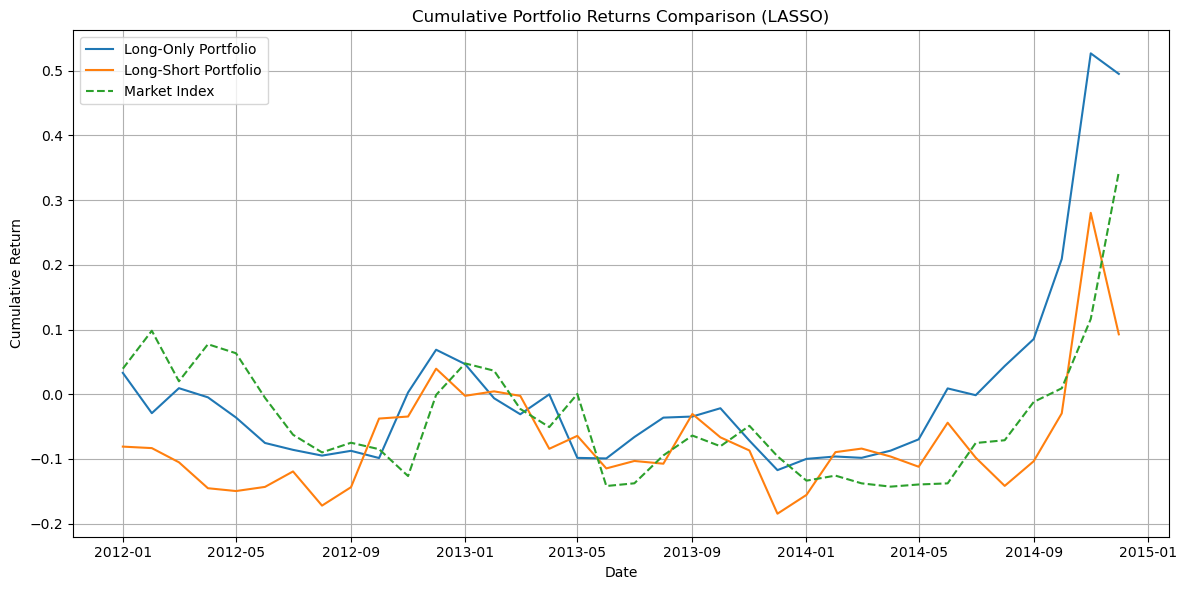

In [12]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))

# Plot all returns
plt.plot(cumulative_returns['Date'], 
         cumulative_returns['Long_Only_Return'],
         label='Long-Only Portfolio')

plt.plot(cumulative_returns['Date'], 
         cumulative_returns['Long_Short_Return'],
         label='Long-Short Portfolio')

plt.plot(cumulative_returns['Date'], 
         cumulative_returns['Market_Return'],
         label='Market Index',
         linestyle='--')

plt.title(f'Cumulative Portfolio Returns Comparison ({model_name})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()